In [1]:
# Loading the Dataset

import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Path to your dataset
dataset_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'  # Replace with your actual path

# Image preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the images to 64x64
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the tensors
])

# Load the dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [2]:
# Defining the Generator

import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [3]:
# Defining the Discriminator 

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size. 1 x 1 x 1
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


In [4]:
# Initializing the models, loss functions and optimizers 

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize Generator and Discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

# Initialize BCELoss function
criterion = torch.nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=3e-4, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=3e-4, betas=(0.5, 0.999))


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import utils as vutils

# Number of epochs to train for
num_epochs = 500  # Adjust this to your needs

# Initialize Generator and Discriminator
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netG = Generator().to(device)
netD = Discriminator().to(device)

# Initialize BCELoss function
criterion = torch.nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/500][0/13]	Loss_D: 1.4296	Loss_G: 3.3509	D(x): 0.5236	D(G(z)): 0.5282 / 0.0362
[1/500][0/13]	Loss_D: 0.0634	Loss_G: 7.8341	D(x): 0.9927	D(G(z)): 0.0543 / 0.0004
[2/500][0/13]	Loss_D: 0.0322	Loss_G: 8.6600	D(x): 0.9899	D(G(z)): 0.0217 / 0.0002
[3/500][0/13]	Loss_D: 0.0008	Loss_G: 10.6508	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000
[4/500][0/13]	Loss_D: 11.7118	Loss_G: 12.0621	D(x): 1.0000	D(G(z)): 1.0000 / 0.0000
[5/500][0/13]	Loss_D: 0.0200	Loss_G: 4.5384	D(x): 0.9935	D(G(z)): 0.0133 / 0.0123
[6/500][0/13]	Loss_D: 3.5350	Loss_G: 13.0496	D(x): 0.9977	D(G(z)): 0.9647 / 0.0000
[7/500][0/13]	Loss_D: 0.0969	Loss_G: 11.4933	D(x): 0.9218	D(G(z)): 0.0000 / 0.0000
[8/500][0/13]	Loss_D: 0.4413	Loss_G: 3.4336	D(x): 0.8045	D(G(z)): 0.1665 / 0.0460
[9/500][0/13]	Loss_D: 0.7243	Loss_G: 2.0192	D(x): 0.6140	D(G(z)): 0.1069 / 0.1690
[10/500][0/13]	Loss_D: 0.4589	Loss_G: 5.5923	D(x): 0.9475	D(G(z)): 0.3158 / 0.0042
[11/500][0/13]	Loss_D: 0.3636	Loss_G: 3.9140	D(x): 0.9823	D(G(z)):

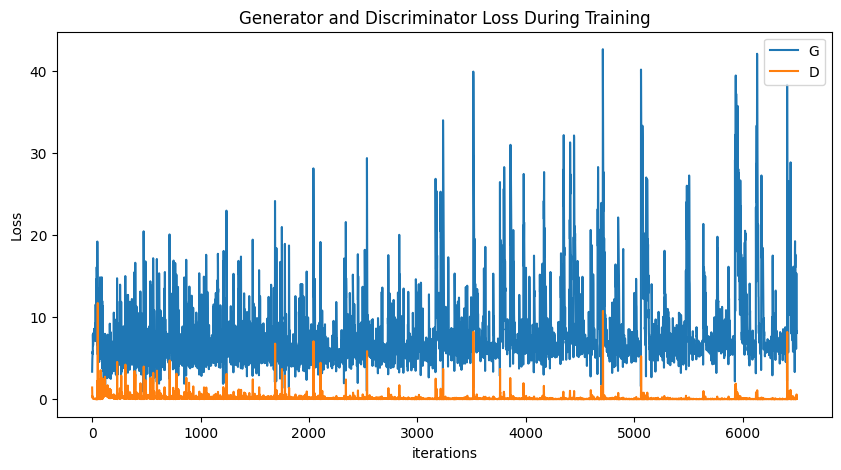

In [6]:
# Inspecting Loss Curves 

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


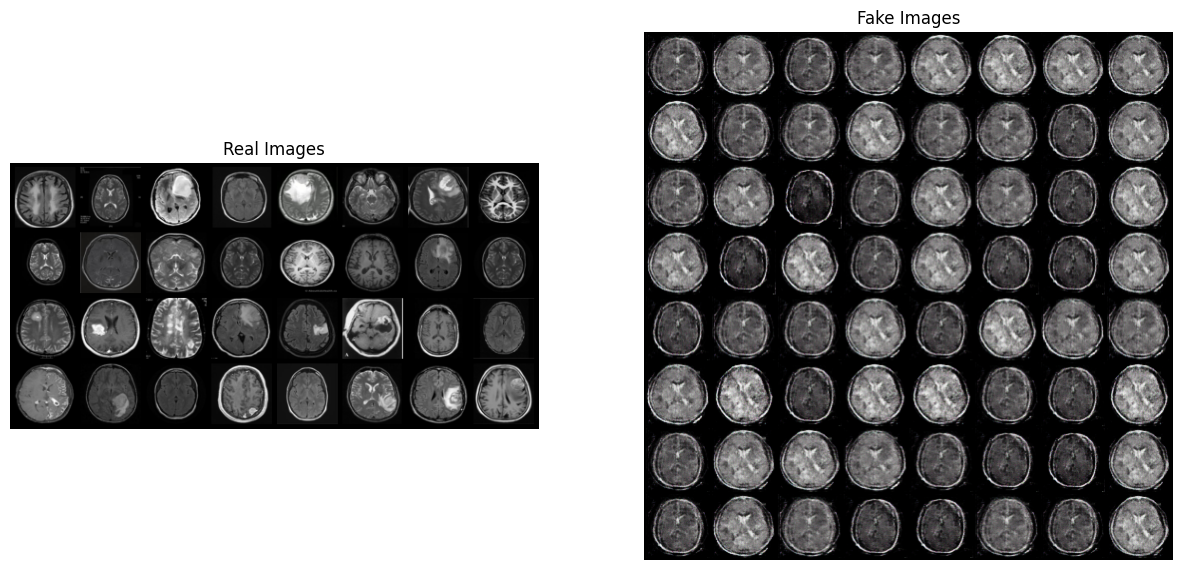

In [7]:
# Visual Inspection Of the Generated Images 
import numpy as np
# Grab a batch of real images from the DataLoader
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


In [8]:
# Corss Entropy Loss 

# Generating the Images 

# Set the Generator to evaluation mode
netG.eval()

# Generate a batch of images with the fixed noise or new noise
with torch.no_grad():
    # If you want to use the same noise each time, use fixed_noise
    # For new images, replace fixed_noise with torch.randn like below
    # noise = torch.randn(batch_size, 100, 1, 1, device=device)
    generated_images = netG(fixed_noise).detach().cpu()


In [9]:
# Preparing the Real Images for the Comparison 

# Get a batch of real images from your DataLoader
real_images, _ = next(iter(train_loader))
real_images = real_images.to(device)

# Make sure to resize this batch to the same size as your generated images if they differ


In [10]:
# Computue the Cross Entropy Loss 

import numpy as np

# Flatten and normalize the real and generated images
real_images_flat = real_images.view(real_images.size(0), -1).cpu().numpy()
generated_images_flat = generated_images.view(generated_images.size(0), -1).cpu().numpy()

# Compute histograms
real_hist = np.histogram(real_images_flat, bins=256, range=(0, 1))[0]
gen_hist = np.histogram(generated_images_flat, bins=256, range=(0, 1))[0]

# Normalize the histograms to create probability distributions
real_hist = real_hist / np.sum(real_hist)
gen_hist = gen_hist / np.sum(gen_hist)

# Use a small value to avoid division by zero during cross-entropy calculation
epsilon = 1e-10
real_hist = np.where(real_hist == 0, epsilon, real_hist)
gen_hist = np.where(gen_hist == 0, epsilon, gen_hist)

# Compute the cross-entropy
cross_entropy = -np.sum(real_hist * np.log(gen_hist))
print(f'Cross-Entropy between real and generated images: {cross_entropy}')


Cross-Entropy between real and generated images: 5.753230734340195
